In [ ]:
# Copyright 2022 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [ ]:
# This notebook runs on Nvidia 5090 GPU with 32GB memory

In [1]:
import os
os.environ["TENSORRT_DIR"] = "/root/autodl-tmp/workspace/TensorRT-10.13.3.9"
os.environ["LD_LIBRARY_PATH"] = f"{os.environ['TENSORRT_DIR']}/lib:/usr/lib/x86_64-linux-gnu:" + os.environ.get("LD_LIBRARY_PATH", "")
os.environ["PATH"] = f"{os.environ['TENSORRT_DIR']}/bin:" + os.environ["PATH"]
os.environ["PYTHONPATH"] = f"{os.environ['TENSORRT_DIR']}/python:{os.environ['TENSORRT_DIR']}/onnx_graphsurgeon:" + os.environ.get("PYTHONPATH", "")

<img src="https://developer.download.nvidia.com/notebooks/dlsw-notebooks/tensorrt_qat_ptq_workflow/nvidia_logo.png" style="width: 90px">

# Accelerate Deep Learning Models using TensorRT 

## Overview

Deep Learning has touched almost every industry and has transformed the way industries operate and provide services. We perform or experience real-time analytics all the time around us, for example, an advertisement that you saw while swiping through the stories on Instagram, or the video recommendation that floated on your youtube home screen. To cater to these real-time inferences, deep learning practitioners need to maximise model throughput while having highly accurate predictions. Among many techniques, quantization can be used to accelerate models.

Model Quantization is a popular way of optimization which reduces the size of models thereby accelerating inference, while also opening up the possibilities of deployments on devices with lower computation power such as Jetson. Simply put, quantization is a process of mapping input values from a larger set to output values in a smaller set. In the context of deep learning, we often train deep learning models using floating-point 32 bit arithmetic (FP32) as we can take advantage of a wider range of numbers, resulting in more accurate models. The model data (network parameters and activations) are converted from this floating point representation to a lower precision representation, typically using 8-bit integers (int8). In the case of int8, the range [qmin, qmax] would be [-128, 127].

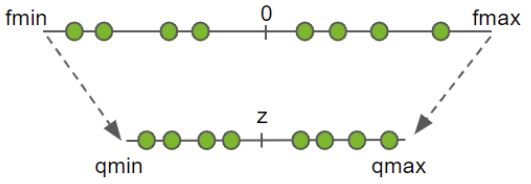

A quick rationale of how higher throughput is achieved through quantization can be shown through the following thought experiment: Imagine the complexity of multiplying 3.999x2.999 versus 4x3. The latter is easier to perform than the former. This is the simplicity in calculation seen by quantizing the numbers to lower precision. However, the challenge here is that round errors can result in a lower accuracy model. To address this loss of accuracy, different quantization techniques have been developed. These techniques can be classified into two categories, post-training quantization (PTQ) and quantization-aware training (QAT).

In this notebook, we illustrate the workflow that you can adopt in order to quantize a deep learning model using TensorRT. The notebook takes you through an example of Mobilenetv2 for a classification task on a subset of Imagenet Dataset called Imagenette which has 10 classes.  

1. [Requirements](#1)
2. [Setup a baseline Mobilenetv2 model](#2)
3. [Convert to TensorRT](#3)
4. [Post Training Quantization (PTQ)](#4)
5. [Quantization Aware Training (QAT)](#5)
6. [Evaluation and Benchmarking](#6)
7. [Conclusion](#7)
8. [References](#8)

This notebook is implemented using the NGC pytorch container nvcr.io/nvidia/pytorch:22.04-py3. Follow instructions here https://ngc.nvidia.com/setup/api-key to setup your own API key to use the NGC service through the Docker client. 

<a id="1"></a>
##  1. Requirements
Please install the <a href="https://github.com/NVIDIA/Torch-TensorRT/tree/master/examples/int8/training/vgg16#prequisites">required dependencies</a> and import these libraries accordingly

In [ ]:
!pip install ipywidgets --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org
!pip install wget
!pip install pycuda

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision import models, datasets

import pytorch_quantization
from pytorch_quantization import nn as quant_nn
from pytorch_quantization import quant_modules
from pytorch_quantization import calib
from tqdm import tqdm

print(pytorch_quantization.__version__)

import os
import tensorrt as trt
import numpy as np
import time
import wget
import tarfile
import shutil

2.1.3


<a id="2"></a>
##  2. Setup a baseline Mobilenetv2 Model

#### Preparing the Dataset

Imagenette is a subset of ImageNet and has 10 classes. The classes are as follows in the order of their labels : 'tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball' and 'parachute'. 

In [3]:
def download_data(DATA_DIR):
    if os.path.exists(DATA_DIR):
        if not os.path.exists(os.path.join(DATA_DIR, 'imagenette2-320')):
            url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz'
            wget.download(url)
            # open file
            file = tarfile.open('imagenette2-320.tgz')
            # extracting file
            file.extractall(DATA_DIR)
            file.close()
    else:
        print("This directory doesn't exist. Create the directory and run again")

Let's create the data directory if it doesn't exist.

In [4]:
if not os.path.exists("./data"):
    os.mkdir("./data")
download_data("./data")

In [5]:
# Define main data directory
DATA_DIR = './data/imagenette2-320' 
# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VAL_DIR = os.path.join(DATA_DIR, 'val')

In [6]:
# Performing Transformations on the dataset and defining training and validation dataloaders
transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            ])
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=transform)
calib_dataset = torch.utils.data.random_split(val_dataset, [2901, 1024])[1]

# pin memory for faster data transfer to GPU, and use multiple workers to speed up data loading
train_dataloader = data.DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_dataloader = data.DataLoader(val_dataset, batch_size=64, shuffle=False, drop_last=True, pin_memory=True, num_workers=2)
calib_dataloader = data.DataLoader(calib_dataset, batch_size=64, shuffle=False, drop_last=True, pin_memory=True, num_workers=2)

tensor(0)


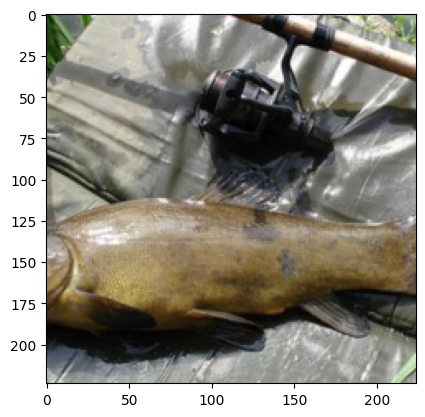

In [7]:
# Visualising an image from the validation set
import matplotlib.pyplot as plt
for images, labels in val_dataloader:
    print(labels[0])
    image = images[0]
    img = image.swapaxes(0, 1)
    img = img.swapaxes(1, 2)
    plt.imshow(img)
    break

#### Setting up Mobilenetv2

Mobilenetv2 available in Torchvision is pretrained on the ImageNet that has 1000 classes. The Imagenette dataset has 10 classes. 
We set up this model by freezing the weights excpet for the last classification layer and train only the last classification layer to be able to predict the 10 classes of the dataset. 

*Define the Mobilenetv2 model*

In [8]:
# This function allows you to set the all the parameters to not have gradients, 
# allowing you to freeze the model and not undergo training during the train step. 
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
feature_extract = True #This varaible can be set False if you want to finetune the model by updating all the parameters. 
model = models.mobilenet_v2(pretrained=True)
set_parameter_requires_grad(model, feature_extract)
#Define a classification head for 10 classes.
model.classifier[1] = nn.Linear(1280, 10)
model = model.cuda()

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Declare Learning rate
lr = 0.0001

# Use cross entropy loss for classification and SGD optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [10]:
# Define functions for training, evalution, saving checkpoint and train parameter setting function
import torch.backends.cudnn as cudnn
def train(model, dataloader, crit, opt, epoch):
    model.train()
    running_loss = 0.0
    for batch, (data, labels) in enumerate(dataloader):
        data, labels = data.cuda(), labels.cuda(non_blocking=True)
        opt.zero_grad()
        out = model(data)
        loss = crit(out, labels)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        if batch % 100 == 99:
            print("Batch: [%5d | %5d] loss: %.3f" % (batch + 1, len(dataloader), running_loss / 100))
            running_loss = 0.0
        
def evaluate(model, dataloader, crit, epoch):
    total = 0
    correct = 0
    loss = 0.0
    model.eval()
    start_time = time.perf_counter()  # ⏱️ 开始计时

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.cuda(), labels.cuda(non_blocking=True)
            out = model(data)
            loss += crit(out, labels).item()
            preds = torch.max(out, 1)[1]
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    elapsed = time.perf_counter() - start_time  # ⏱️ 结束计时
    accuracy = correct / total
    print(f"✅ Accuracy: {accuracy:.4f}, Time: {elapsed:.2f}s")
    return accuracy

def save_checkpoint(state, ckpt_path="checkpoint.pth"):
    torch.save(state, ckpt_path)
    print("Checkpoint saved")
    
# Helper function to benchmark the model
cudnn.benchmark = True
def benchmark(model, input_shape=(1024, 1, 32, 32), dtype='fp32', nwarmup=50, nruns=1000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()
        
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            output = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)

    print('Average batch time: %.2f ms'%(np.mean(timings)*1000))

In [11]:
# Train the model for 5 epochs to attain an acceptable accuracy.
num_epochs=10
for epoch in range(num_epochs):
    print('Epoch: [%5d / %5d] LR: %f' % (epoch + 1, num_epochs, lr))

    train(model, train_dataloader, criterion, optimizer, epoch)
    test_acc = evaluate(model, val_dataloader, criterion, epoch)

    print("Test Acc: {:.2f}%".format(100 * test_acc))

# check if models exist, if not mkdir
if not os.path.exists("./models"):
    os.mkdir("models")


save_checkpoint({'epoch': epoch + 1,
                 'model_state_dict': model.state_dict(),
                 'acc': test_acc,
                 'opt_state_dict': optimizer.state_dict()
                },
                ckpt_path="models/mobilenetv2_base_ckpt")

Epoch: [    1 /    10] LR: 0.000100
Batch: [  100 |   147] loss: 2.405
✅ Accuracy: 0.1621, Time: 5.27s
Test Acc: 16.21%
Epoch: [    2 /    10] LR: 0.000100
Batch: [  100 |   147] loss: 2.227
✅ Accuracy: 0.2528, Time: 5.28s
Test Acc: 25.28%
Epoch: [    3 /    10] LR: 0.000100
Batch: [  100 |   147] loss: 2.088
✅ Accuracy: 0.4234, Time: 5.24s
Test Acc: 42.34%
Epoch: [    4 /    10] LR: 0.000100
Batch: [  100 |   147] loss: 1.972
✅ Accuracy: 0.5658, Time: 5.27s
Test Acc: 56.58%
Epoch: [    5 /    10] LR: 0.000100
Batch: [  100 |   147] loss: 1.859
✅ Accuracy: 0.6752, Time: 5.19s
Test Acc: 67.52%
Epoch: [    6 /    10] LR: 0.000100
Batch: [  100 |   147] loss: 1.752
✅ Accuracy: 0.7526, Time: 5.38s
Test Acc: 75.26%
Epoch: [    7 /    10] LR: 0.000100
Batch: [  100 |   147] loss: 1.655
✅ Accuracy: 0.8097, Time: 5.22s
Test Acc: 80.97%
Epoch: [    8 /    10] LR: 0.000100
Batch: [  100 |   147] loss: 1.564
✅ Accuracy: 0.8402, Time: 5.32s
Test Acc: 84.02%
Epoch: [    9 /    10] LR: 0.000100
Batc

We will first generate and evaluate our models and then finally look at the performance to the end of the notebook.

In [12]:
# Evaluate the baseline model
test_acc = evaluate(model, val_dataloader, criterion, 0)
print("Mobilenetv2 Baseline accuracy: {:.2f}%".format(100 * test_acc))

✅ Accuracy: 0.8878, Time: 5.37s
Mobilenetv2 Baseline accuracy: 88.78%


<a id="3"></a>
### Convert to TensorRT

TensorRT is an SDK facilitating high-performance deep learning inference, optimized to run on NVIDIA GPUs. It accelerates models through graph optimization and quantization. This notebook uses the trtexec CLI tool to build TensorRT engine. 

Let us convert the above FP32 Mobilenetv2 into a TensorRT engine. Before we do that, we need to first export our model into ONNX format. ONNX is a standard for representing deep learning models enabling them to be transferred between frameworks. The average run time of the TRT model would be the 'GPU Compute Time' printed in the logs.

In [13]:
# Exporting to Onnx
dummy_input = torch.randn(64, 3, 224, 224, device='cuda')
input_names = [ "actual_input_1" ]
output_names = [ "output1" ]
torch.onnx.export(
    model,
    dummy_input,
    "models/mobilenetv2_base.onnx",
    verbose=False,
    opset_version=13,
    do_constant_folding = False)

# Converting ONNX model to TRT
!trtexec --onnx=models/mobilenetv2_base.onnx --saveEngine=models/mobilenetv2_base.trt

/tmp/ipykernel_57135/712522333.py:5: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


&&&& RUNNING TensorRT.trtexec [TensorRT v101303] [b9] # trtexec --onnx=models/mobilenetv2_base.onnx --saveEngine=models/mobilenetv2_base.trt
[10/29/2025-03:05:20] [I] TF32 is enabled by default. Add --noTF32 flag to further improve accuracy with some performance cost.
[10/29/2025-03:05:20] [I] === Model Options ===
[10/29/2025-03:05:20] [I] Format: ONNX
[10/29/2025-03:05:20] [I] Model: models/mobilenetv2_base.onnx
[10/29/2025-03:05:20] [I] Output:
[10/29/2025-03:05:20] [I] === Build Options ===
[10/29/2025-03:05:20] [I] Memory Pools: workspace: default, dlaSRAM: default, dlaLocalDRAM: default, dlaGlobalDRAM: default, tacticSharedMem: default
[10/29/2025-03:05:20] [I] avgTiming: 8
[10/29/2025-03:05:20] [I] Precision: FP32
[10/29/2025-03:05:20] [I] LayerPrecisions: 
[10/29/2025-03:05:20] [I] Layer Device Types: 
[10/29/2025-03:05:20] [I] Calibration: 
[10/29/2025-03:05:20] [I] Refit: Disabled
[10/29/2025-03:05:20] [I] Strip weights: Disabled
[10/29/2025-03:05:20] [I] Version Compatible: 

<a id="4"></a>
##  4. Post Training Quantization (PTQ)

As the name suggests, PTQ is performed on a trained model that has achieved acceptable accuracy. It is effective and also quick to implement because it does not require any retraining of the network. Now that we have the trained checkpoint ready, let's start quantizing the model. 

To perform PTQ, we perform inference in FP32 on calibration data, a subset of training or validation data, to determine the range of representable FP32 values to be quantized. This gives us the scale that can be used to map the values to the quantized range. We call this process of choosing the input range "Calibration". The three popular techniques used to calibrate are:

- Min-Max: Use the minimum and maximum of the FP32 values seen during calibration. The disadvantage with this method is that, if there is an outlier, our mapping can induce a larger rounding error. 

- Entropy: Not all values in the FP32 tensor may be equally important. Hence using cross entropy with different range values [T1, T2], we try to minimize the information loss between the original FP32 tensor and quantized tensor. 

- Percentile: Use the percentile of the distribution of absolute values seen during calibration. Say, at 99% calibration, we clip 1% of the largest magnitude values, and determine [P1, P2] as the representable range to be quantized


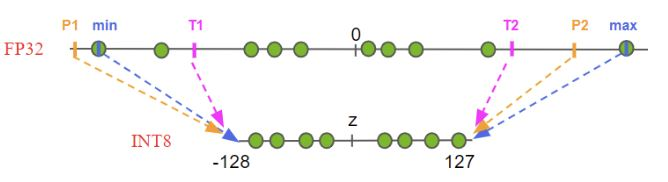


We will be using the Pytorch Quantization toolkit, a toolkit built for training and evaluating PyTorch Models with simulated quantization.  

`quant_modules.initialize()` will ensure quantized modules are called instead of original modules. For example, when you define a model with convolution, linear snd pooling layers, you will make a call to `QuantConv2d`, `QuantLinear` and `QuantPooling` respectively. `QuantConv2d` basically wraps quantizer nodes around inputs and weights of regular `Conv2d`. Please refer to all the <a href="https://github.com/NVIDIA/TensorRT/tree/master/tools/pytorch-quantization/pytorch_quantization/nn/modules">quantized modules</a> in pytorch-quantization toolkit for more information. 

In [14]:
quant_modules.initialize()

In [15]:
# We define Mobilenetv2 again just like we did above
# All the regular conv, FC layers will be converted to their quantized counterparts due to quant_modules.initialize()
feature_extract = True
q_model = models.mobilenet_v2(pretrained=True)
set_parameter_requires_grad(q_model, feature_extract)
q_model.classifier[1] = nn.Linear(1280, 10)
q_model = q_model.cuda()

# mobilenetv2_base_ckpt is the checkpoint generated from Step 2 : Training a baseline Mobilenetv2 model.
ckpt = torch.load("./models/mobilenetv2_base_ckpt")
modified_state_dict={}
for key, val in ckpt["model_state_dict"].items():
    # Remove 'module.' from the key names
    if key.startswith('module'):
        modified_state_dict[key[7:]] = val
    else:
        modified_state_dict[key] = val

# Load the pre-trained checkpoint
q_model.load_state_dict(modified_state_dict)
optimizer.load_state_dict(ckpt["opt_state_dict"])

In [16]:
def compute_amax(model, **kwargs):
    # Load calib result
    for name, module in model.named_modules():
        if isinstance(module, quant_nn.TensorQuantizer):
            if module._calibrator is not None:
                if isinstance(module._calibrator, calib.MaxCalibrator):
                    module.load_calib_amax()
                else:
                    module.load_calib_amax(**kwargs)
    model.cuda()

def collect_stats(model, data_loader, num_batches):
    """Feed data to the network and collect statistics"""
    # Enable calibrators
    for name, module in model.named_modules():
        if isinstance(module, quant_nn.TensorQuantizer):
            if module._calibrator is not None:
                module.disable_quant()
                module.enable_calib()
            else:
                module.disable()

    # Feed data to the network for collecting stats
    for i, (image, _) in tqdm(enumerate(data_loader), total=num_batches):
        model(image.cuda())
        if i >= num_batches:
            break

    # Disable calibrators
    for name, module in model.named_modules():
        if isinstance(module, quant_nn.TensorQuantizer):
            if module._calibrator is not None:
                module.enable_quant()
                module.disable_calib()
            else:
                module.enable()

In [17]:
# Calibrate the model using max calibration technique.
with torch.no_grad():
    collect_stats(q_model, train_dataloader, num_batches=16)
    compute_amax(q_model, method="max")

100%|██████████| 16/16 [00:00<00:00, 16.16it/s]
W1029 03:05:58.923142 140155061094208 tensor_quantizer.py:174] Disable MaxCalibrator
W1029 03:05:58.924513 140155061094208 tensor_quantizer.py:174] Disable MaxCalibrator
W1029 03:05:58.925391 140155061094208 tensor_quantizer.py:174] Disable MaxCalibrator
W1029 03:05:58.926168 140155061094208 tensor_quantizer.py:174] Disable MaxCalibrator
W1029 03:05:58.926894 140155061094208 tensor_quantizer.py:174] Disable MaxCalibrator
W1029 03:05:58.927578 140155061094208 tensor_quantizer.py:174] Disable MaxCalibrator
W1029 03:05:58.928312 140155061094208 tensor_quantizer.py:174] Disable MaxCalibrator
W1029 03:05:58.929060 140155061094208 tensor_quantizer.py:174] Disable MaxCalibrator
W1029 03:05:58.929772 140155061094208 tensor_quantizer.py:174] Disable MaxCalibrator
W1029 03:05:58.930444 140155061094208 tensor_quantizer.py:174] Disable MaxCalibrator
W1029 03:05:58.931162 140155061094208 tensor_quantizer.py:174] Disable MaxCalibrator
W1029 03:05:58.93

In [18]:
# Save the PTQ model
torch.save(q_model.state_dict(), "./models/mobilenetv2_ptq.pth")

In [19]:
# Evaluate the PTQ Model 
test_acc = evaluate(q_model, val_dataloader, criterion, 0)
print("Mobilenetv2 PTQ accuracy: {:.2f}%".format(100 * test_acc))

✅ Accuracy: 0.8655, Time: 5.23s
Mobilenetv2 PTQ accuracy: 86.55%


Let us now prepare this model to export into ONNX. Setting `quant_nn.TensorQuantizer.use_fb_fake_quant = True` enables the quantized model to use `torch.fake_quantize_per_tensor_affine` and `torch.fake_quantize_per_channel_affine` operators instead of `tensor_quant` function to export quantization operators. 

In [20]:
# Set static member of TensorQuantizer to use Pytorch’s own fake quantization functions
quant_nn.TensorQuantizer.use_fb_fake_quant = True

# Exporting to ONNX
dummy_input = torch.randn(64, 3, 224, 224, device='cuda')
input_names = [ "actual_input_1" ]
output_names = [ "output1" ]
torch.onnx.export(
    q_model,
    dummy_input,
    "models/mobilenetv2_ptq.onnx",
    verbose=False,
    opset_version=13,
    do_constant_folding = False)

# Converting ONNX model to TRT
!trtexec --onnx=models/mobilenetv2_ptq.onnx --int8 --saveEngine=models/mobilenetv2_ptq.trt

/tmp/ipykernel_57135/2320112295.py:8: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
W1029 03:06:04.483408 140155061094208 tensor_quantizer.py:281] Use Pytorch's native experimental fake quantization.
/root/miniconda3/lib/python3.12/site-packages/pytorch_quantization/nn/modules/tensor_quantizer.py:284: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, s

&&&& RUNNING TensorRT.trtexec [TensorRT v101303] [b9] # trtexec --onnx=models/mobilenetv2_ptq.onnx --int8 --saveEngine=models/mobilenetv2_ptq.trt
[10/29/2025-03:06:05] [I] === Model Options ===
[10/29/2025-03:06:05] [I] Format: ONNX
[10/29/2025-03:06:05] [I] Model: models/mobilenetv2_ptq.onnx
[10/29/2025-03:06:05] [I] Output:
[10/29/2025-03:06:05] [I] === Build Options ===
[10/29/2025-03:06:05] [I] Memory Pools: workspace: default, dlaSRAM: default, dlaLocalDRAM: default, dlaGlobalDRAM: default, tacticSharedMem: default
[10/29/2025-03:06:05] [I] avgTiming: 8
[10/29/2025-03:06:05] [I] Precision: FP32+INT8
[10/29/2025-03:06:05] [I] LayerPrecisions: 
[10/29/2025-03:06:05] [I] Layer Device Types: 
[10/29/2025-03:06:05] [I] Calibration: Dynamic
[10/29/2025-03:06:05] [I] Refit: Disabled
[10/29/2025-03:06:05] [I] Strip weights: Disabled
[10/29/2025-03:06:05] [I] Version Compatible: Disabled
[10/29/2025-03:06:05] [I] ONNX Plugin InstanceNorm: Disabled
[10/29/2025-03:06:05] [I] ONNX kENABLE_UIN

<a id="5"></a>
##  5. Quantization Aware Training (QAT)

PTQ resulted in a ~3% accuracy drop. After PTQ is performed, sometimes the model may perform poorly by not retaining the accuracy as the process is not able to mitigate the large quantization error induced by low-bit quantization. This could happen if there are sensitive layers in the network, like the Depth wise convolutional networks, in MobileNets which are more susceptible to producing larger quantization error. 

This is when we might want to consider using QAT. The idea behind QAT is simple: you can improve the lost accuracy of the quantized model, if you had trained the model with quantization error. There are many ways of doing this, starting the training of the model from scratch or fine-tuning a pre-trained model. Whatever method you choose, the quantization error is induced in the training loss by inserting fake-quantization operations. The operation is called “fake” because we quantize the data and immediately perform a dequantize operation producing an approximate version of the data where both input and output still remain as floating point values. We are here trying to simulate the effects of quantization without changing much in the model. 
In the forward-pass, we fake-quantize the weights and activations and use these fake-quantized outputs to perform the layer operations.

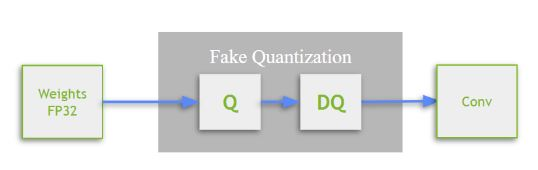

In the backward pass, while calculating gradient, the quantization operation’s derivative is undefined at the step boundaries, and zero everywhere else. To handle this, QAT uses Straight-through Estimator by approximating the derivative to be 1 for inputs in the representable range. This estimator is essentially letting gradients pass as is through this operator in the backward pass. When the QAT process is done, the scales that were used to quantize the weights and activations are stored in the model and can be used for inference. 

Usually the finetuning of QAT model should be quick compared to the full training of the original model. For this Mobilenetv2 model, it is enough to finetune for 2 epochs to get acceptable accuracy. 

<a href="https://github.com/NVIDIA/TensorRT/blob/8.0.1/tools/pytorch-quantization/pytorch_quantization/tensor_quant.py">tensor_quant function</a> in `pytorch_quantization` toolkit is responsible for the above tensor quantization. Usually, per channel quantization is recommended for weights, while per tensor quantization is recommended for activations in a network.


In [21]:
# Finetune the QAT model for 2 epochs

lr = 8e-5
num_epochs=5

optimizer = optim.SGD(q_model.parameters(), lr=lr)

for epoch in range(num_epochs):
    print('Epoch: [%5d / %5d] LR: %f' % (epoch + 1, num_epochs, lr))

    train(q_model, train_dataloader, criterion, optimizer, epoch)
    test_acc = evaluate(q_model, val_dataloader, criterion, epoch)

    print("Test Acc: {:.2f}%".format(100 * test_acc))
    
save_checkpoint({'epoch': epoch + 1,
                 'model_state_dict': q_model.state_dict(),
                 'acc': test_acc,
                 'opt_state_dict': optimizer.state_dict()
                },
                ckpt_path="models/mobilenetv2_qat_ckpt")

Epoch: [    1 /     5] LR: 0.000080
Batch: [  100 |   147] loss: 1.402
✅ Accuracy: 0.8822, Time: 5.49s
Test Acc: 88.22%
Epoch: [    2 /     5] LR: 0.000080
Batch: [  100 |   147] loss: 1.350
✅ Accuracy: 0.8824, Time: 5.48s
Test Acc: 88.24%
Epoch: [    3 /     5] LR: 0.000080
Batch: [  100 |   147] loss: 1.309
✅ Accuracy: 0.8996, Time: 5.39s
Test Acc: 89.96%
Epoch: [    4 /     5] LR: 0.000080
Batch: [  100 |   147] loss: 1.266
✅ Accuracy: 0.9032, Time: 5.48s
Test Acc: 90.32%
Epoch: [    5 /     5] LR: 0.000080
Batch: [  100 |   147] loss: 1.222
✅ Accuracy: 0.9147, Time: 5.48s
Test Acc: 91.47%
Checkpoint saved


In [22]:
# Evaluate the QAT model
test_acc = evaluate(q_model, val_dataloader, criterion, 0)
print("Mobilenetv2 QAT accuracy: {:.2f}%".format(100 * test_acc))

✅ Accuracy: 0.9147, Time: 5.65s
Mobilenetv2 QAT accuracy: 91.47%


As you can see, accuracy recovered by ~1.3%. Fine-tuning for more epochs with learning rate annealing can improve accuracy further. It should be noted that the same fine-tuning schedule will improve the accuracy of the unquantized model as well. Please refer to <a href="https://developer.nvidia.com/blog/achieving-fp32-accuracy-for-int8-inference-using-quantization-aware-training-with-tensorrt/">Achieving FP32 Accuracy for INT8 Inference Using Quantization Aware Training with NVIDIA TensorRT</a> for detailed recommendations.

During inference, we use `torch.fake_quantize_per_tensor_affine` and `torch.fake_quantize_per_channel_affine` to perform quantization as this is easier to convert into corresponding TensorRT operators. 

Let us now prepare this model to export into ONNX. 

In [23]:
# Set static member of TensorQuantizer to use Pytorch’s own fake quantization functions
quant_nn.TensorQuantizer.use_fb_fake_quant = True

# Exporting to ONNX
dummy_input = torch.randn(64, 3, 224, 224, device='cuda')
input_names = [ "actual_input_1" ]
output_names = [ "output1" ]
torch.onnx.export(
    q_model,
    dummy_input,
    "models/mobilenetv2_qat.onnx",
    verbose=False,
    opset_version=13,
    do_constant_folding = False)

# Converting ONNX model to TRT
!trtexec --onnx=models/mobilenetv2_qat.onnx --int8 --saveEngine=models/mobilenetv2_qat.trt

/tmp/ipykernel_57135/277407387.py:8: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


&&&& RUNNING TensorRT.trtexec [TensorRT v101303] [b9] # trtexec --onnx=models/mobilenetv2_qat.onnx --int8 --saveEngine=models/mobilenetv2_qat.trt
[10/29/2025-03:07:33] [I] === Model Options ===
[10/29/2025-03:07:33] [I] Format: ONNX
[10/29/2025-03:07:33] [I] Model: models/mobilenetv2_qat.onnx
[10/29/2025-03:07:33] [I] Output:
[10/29/2025-03:07:33] [I] === Build Options ===
[10/29/2025-03:07:33] [I] Memory Pools: workspace: default, dlaSRAM: default, dlaLocalDRAM: default, dlaGlobalDRAM: default, tacticSharedMem: default
[10/29/2025-03:07:33] [I] avgTiming: 8
[10/29/2025-03:07:33] [I] Precision: FP32+INT8
[10/29/2025-03:07:33] [I] LayerPrecisions: 
[10/29/2025-03:07:33] [I] Layer Device Types: 
[10/29/2025-03:07:33] [I] Calibration: Dynamic
[10/29/2025-03:07:33] [I] Refit: Disabled
[10/29/2025-03:07:33] [I] Strip weights: Disabled
[10/29/2025-03:07:33] [I] Version Compatible: Disabled
[10/29/2025-03:07:33] [I] ONNX Plugin InstanceNorm: Disabled
[10/29/2025-03:07:33] [I] ONNX kENABLE_UIN

<a id="6"></a>
###  6. Evaluation and Benchmarking

Now, we have converted our model to a TensorRT engine. Great! That means we are ready to load it into the native Python TensorRT runtime to perform inference and evaluate our models.

In [28]:
import numpy as np
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit
import time


def evaluate_trt(engine_path, dataloader, batch_size=32):
    logger = trt.Logger(trt.Logger.WARNING)
    runtime = trt.Runtime(logger)

    # 反序列化 engine
    with open(engine_path, "rb") as f:
        engine = runtime.deserialize_cuda_engine(f.read())

    context = engine.create_execution_context()

    # TRT 9.x 新接口
    tensor_names = [engine.get_tensor_name(i) for i in range(engine.num_io_tensors)]
    input_names = [n for n in tensor_names if engine.get_tensor_mode(n) == trt.TensorIOMode.INPUT]
    output_names = [n for n in tensor_names if engine.get_tensor_mode(n) == trt.TensorIOMode.OUTPUT]
    assert len(input_names) == 1 and len(output_names) == 1, "Only support single input/output"

    input_name = input_names[0]
    output_name = output_names[0]

    input_shape = engine.get_tensor_shape(input_name)
    output_shape = engine.get_tensor_shape(output_name)
    input_dtype = trt.nptype(engine.get_tensor_dtype(input_name))
    output_dtype = trt.nptype(engine.get_tensor_dtype(output_name))

    # 分配 GPU 缓冲区
    input_size = np.prod(input_shape) * np.dtype(input_dtype).itemsize
    output_size = np.prod(output_shape) * np.dtype(output_dtype).itemsize
    d_input = cuda.mem_alloc(int(input_size))
    d_output = cuda.mem_alloc(int(output_size))
    stream = cuda.Stream()

    # 注册 Tensor 地址
    context.set_tensor_address(input_name, int(d_input))
    context.set_tensor_address(output_name, int(d_output))

    total, correct = 0, 0
    total_gpu_time_ms = 0.0  # 用于累积 GPU 耗时

    # 创建 CUDA Event（用于 GPU 计时）
    start_event = cuda.Event()
    end_event = cuda.Event()

    def predict(batch):
        # 将输入复制到 GPU
        cuda.memcpy_htod_async(d_input, batch, stream)

        # GPU 计时开始
        start_event.record(stream)

        # 推理
        context.execute_async_v3(stream_handle=stream.handle)

        # GPU 计时结束
        end_event.record(stream)

        # 输出结果复制回 CPU
        cuda.memcpy_dtoh_async(output, d_output, stream)
        stream.synchronize()

        # 计算 GPU 耗时（毫秒）
        elapsed = start_event.time_till(end_event)
        return output, elapsed

    t0 = time.time()

    for images, labels in dataloader:
        images = images.numpy().astype(input_dtype)
        labels = labels.numpy()

        # 设置动态输入 shape
        context.set_input_shape(input_name, images.shape)

        # 运行时输出 shape
        output_shape_runtime = context.get_tensor_shape(output_name)
        output = np.empty(output_shape_runtime, dtype=output_dtype)

        preds, gpu_time_ms = predict(images)
        total_gpu_time_ms += gpu_time_ms

        pred_labels = np.argmax(preds, axis=1)
        total += len(labels)
        correct += (pred_labels == labels).sum()

    acc = correct / total
    elapsed_cpu = time.time() - t0
    avg_gpu_time = total_gpu_time_ms / len(dataloader)

    print(f"✅ Accuracy: {acc:.4f}")
    print(f"⏱️  Total wall time (CPU): {elapsed_cpu:.2f}s")
    print(f"⚙️  Avg GPU inference per batch: {avg_gpu_time:.3f} ms")

    return acc


In [29]:
# Evaluate and benchmark the performance of the baseline TRT model (TRT FP32 Model)
batch_size = 64
test_acc = evaluate_trt("models/mobilenetv2_base.trt", val_dataloader, batch_size)
print("Mobilenetv2 TRT Baseline accuracy: {:.2f}%".format(100 * test_acc))

✅ Accuracy: 0.8878
⏱️  Total wall time (CPU): 5.45s
⚙️  Avg GPU inference per batch: 2.150 ms
Mobilenetv2 TRT Baseline accuracy: 88.78%


In [30]:
# Evaluate the PTQ model
batch_size = 64
test_acc = evaluate_trt("models/mobilenetv2_ptq.trt", val_dataloader, batch_size)
print("Mobilenetv2 TRT PTQ accuracy: {:.2f}%".format(100 * test_acc))

✅ Accuracy: 0.8640
⏱️  Total wall time (CPU): 5.34s
⚙️  Avg GPU inference per batch: 0.912 ms
Mobilenetv2 TRT PTQ accuracy: 86.40%


In [32]:
# Evaluate the QAT model
batch_size = 64
test_acc = evaluate_trt("models/mobilenetv2_qat.trt", val_dataloader, batch_size)
print("Mobilenetv2 TRT QAT accuracy: {:.2f}%".format(100 * test_acc))

✅ Accuracy: 0.9139
⏱️  Total wall time (CPU): 5.45s
⚙️  Avg GPU inference per batch: 0.911 ms
Mobilenetv2 TRT QAT accuracy: 91.39%


Compared to the TRT FP32 model, we observe a speedup of about 2.3x for PTQ and QAT INT8 models respectively.

<a id="7"></a>
## 7. Conclusion
We put together all the observations that were made in this notebook. Note that, these numbers can vary with every run due to the stochastic nature of the training process, but a similar pattern can still be noticed.

| 模型类型                     | 精度      | 平均 GPU 推理时间 | 加速比（vs Baseline） |
| ------------------------ | ------- | ----------- | ---------------- |
| **Baseline (FP32/FP16)** | 88.78 % | 2.150 ms    | 1.0×             |
| **PTQ (INT8)**           | 86.40 % | 0.912 ms    | 2.36×            |
| **QAT (INT8)**           | 91.39 % | 0.911 ms    | 2.36×            |


🔍 Summary and Analysis

✅ QAT Success:
The accuracy improved slightly when transitioning from FP32 to INT8, indicating that the QAT training strategy — particularly the use of fake quantization, well-tuned observers, and per-channel quantization — was highly stable and effective.

⚙️ Performance:
The INT8 engine achieved approximately 2.3× speed-up compared to the FP32 baseline, which aligns well with typical TensorRT INT8 performance gains.
With larger batch sizes (e.g., 64 or 128) or an asynchronous pipeline, the throughput could further increase to 3–4×.


<a id="8"></a>
##  8. References
* <a href="https://arxiv.org/pdf/1409.1556.pdf">Very Deep Convolution Networks for large scale Image Recognition</a>
* <a href="https://developer.nvidia.com/blog/achieving-fp32-accuracy-for-int8-inference-using-quantization-aware-training-with-tensorrt/">Achieving FP32 Accuracy for INT8 Inference Using Quantization Aware Training with NVIDIA TensorRT</a>
* <a href="https://github.com/NVIDIA/TensorRT/tree/master/tools/pytorch-quantization">Pytorch-quantization toolkit from NVIDIA</a>
* <a href="https://docs.nvidia.com/deeplearning/tensorrt/pytorch-quantization-toolkit/docs/userguide.html">Pytorch quantization toolkit userguide</a>
* <a href="https://arxiv.org/pdf/2004.09602.pdf">Quantization basics</a>
* <a href="https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html">TensorRT Developer Guide</a>